## Denoise Validation


In [1]:
import scanpy as sc
from scprint import scPrint
from scdataloader import Preprocessor

import numpy as np
import anndata as ad

from scprint.tasks import Denoiser, withknn
from scdataloader.utils import downsample_profile
from scipy.stats import spearmanr

%load_ext autoreload
%autoreload 2

import torch
torch.set_float32_matmul_precision('medium')

💡 connected lamindb: jkobject/scprint


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:53: DeprecationWarning: jax.core.Shape is deprecated. Use Shape = Sequence[int | Any].
  Shape = jax.core.Shape
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:54: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  PRNGKey = jax.random.KeyArray
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_types.py:9: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.i

In [2]:
# model = scPrint.load_from_checkpoint('../../data/tensorboard/scprint_test/urxxwu28/checkpoints/epoch=0-step=20000.ckpt') #chocolate-surf-8
# '../../data/main/gene_embeddings.parquet')
model = scPrint.load_from_checkpoint(
    '../data/temp/o2uniqsx/epoch=18-step=133000.ckpt', precpt_gene_emb=None)
# ../../data/temp/epoch=4-step=12500.ckpt latest model maestro (fortuitous laugther)
# ../../data/logs/scprint_test/f4vao230/checkpoints/epoch=10-step=27500.ckpt looked good as a training run (vermlillion noodle)
# d1792z9k/epoch=3-step=10000.ckpt
# '../../data/temp/d1792z9k/epoch=3-step=10000.ckpt'
# '../../data/temp/6q3dzi3x/epoch=3-step=10000.ckpt'
# '../../data/temp/grsachbg/epoch=2-step=15000.ckpt'
# ../../data/temp/za9mg1w3/epoch=7-step=40000.ckpt
# post debug
# "../lightning_logs/version_14/checkpoints/epoch=1-step=5000.ckpt"

RuntimeError caught: scPrint is not attached to a `Trainer`.



In [ ]:
#'/pasteur/appa/scratch/jkalfon/scprint/.lamindb/R4ZHoQegxXdSFNFY5LGe.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/SHV11AEetZOms4Wh7Ehb.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/V6DPJx8rP3wWRQ43LMHb.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/Gz5G2ETTEuuRDgwm7brA.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/YyBdEsN89p2aF4xJY1CW.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/SO5yBTUDBgkAmz0QbG8K.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/r4iCehg3Tw5IbCLiCIbl.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/SqvXr3i3PGXM8toXzUf9.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/REIyQZE6OMZm1S3W2Dxi.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/rYZ7gs0E0cqPOLONC8ia.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/FcwMDDbAQPNYIjcYNxoc.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/fvU5BAMJrm7vrgDmZM0z.h5ad', '/pasteur/appa/scratch/jkalfon/scprint/.lamindb/gNNpgpo6gATjuxTE7CCp.h5ad'

In [3]:
#adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/R4ZHoQegxXdSFNFY5LGe.h5ad')
#adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/gNNpgpo6gATjuxTE7CCp.h5ad')
adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/yBCKp6HmXuHa0cZptMo7.h5ad')
#adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/REIyQZE6OMZm1S3W2Dxi.h5ad')


adata.layers['true'] = adata.X.copy()
adata

AnnData object with n_obs × n_vars = 15728 × 70116
    obs: 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'tissue_section_uuid', 'tissue_section_thickness', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'leiden_3', 'leide

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


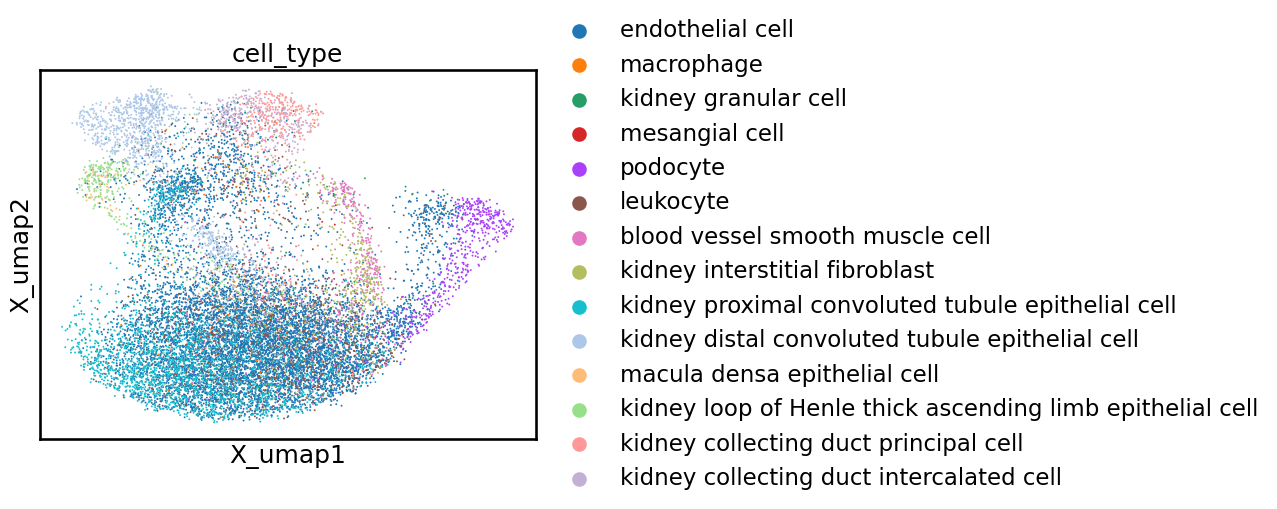

In [25]:
sc.pl.embedding(adata, basis="X_umap", color='cell_type')

In [ ]:
adata.obs.cell_type.value_counts()

## regular denoise

In [5]:
model

scPrint(
  (gene_encoder): GeneEncoder(
    (embedding): Embedding(44756, 512)
  )
  (expr_encoder): ContinuousValueEncoder(
    (encoder): ModuleList(
      (0): Linear(in_features=1, out_features=512, bias=True)
      (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (pos_encoder): PositionalEncoding()
  (class_encoder): CategoryValueEncoder(
    (embedding): Embedding(7, 512)
  )
  (depth_encoder): ContinuousValueEncoder(
    (encoder): ModuleList(
      (0): Linear(in_features=1, out_features=512, bias=True)
      (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (transformer): FlashTransformerEncoder(
    (blocks): ModuleList(
      (0): Block(
        (mixer): MHA(
          (Wqkv): Linear(in_feat

In [7]:
denoise = Denoiser(
    model,
    batch_size=30,
    max_len=4000,
    plot_corr_size=1_000,
    doplot=False,
    num_workers=8,
    predict_depth_mult=10,
    downsample = 0.7,
    how="most var"
)
metrics, idx, genes, expr = denoise(adata)
metrics

4000


100%|██████████| 334/334 [03:46<00:00,  1.48it/s]


{'reco2noisy': nan, 'reco2full': nan, 'noisy2full': 0.24781540778242164}

# on random expr

In [11]:
denoise.model.expr_pred[0].cpu().numpy()

array([[0.00193379, 0.00170323, 0.00200298, ..., 0.00151489, 0.00708733,
        0.00156297],
       [0.00052571, 0.00072278, 0.00060391, ..., 0.00041587, 0.00272776,
        0.00045764],
       [0.00031398, 0.00088576, 0.00043422, ..., 0.00025777, 0.00203149,
        0.00031521],
       ...,
       [0.00022841, 0.00049405, 0.00031404, ..., 0.00020515, 0.00137884,
        0.00025233],
       [0.00097777, 0.00147355, 0.00116113, ..., 0.00085617, 0.00419367,
        0.00089027],
       [0.03409366, 0.03356509, 0.04407741, ..., 0.02718184, 0.16569789,
        0.03221625]], dtype=float32)

In [25]:
denoise = Denoiser(
    model,
    batch_size=40,
    max_len=2200,
    plot_corr_size=1_000,
    doplot=False,
    predict_depth_mult=10,
    downsample = 0.7,
    how="random expr"
)
metrics, idx, genes, expr = denoise(adata)
metrics

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

adding on disk
AnnData object with n_obs × n_vars = 1000 × 424
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'


{'reco2noisy': 0.26794909415027135,
 'reco2full': 0.5975616966061212,
 'noisy2full': 0.2960321624095487}

# aggregate with KNN

In [16]:
from anndata import AnnData
subadata = AnnData(X=expr.cpu().numpy(), obs=adata.obs.iloc[idx], var=adata.var.loc[genes])

In [17]:
nadata = withknn(subadata, seed=42, k=20)

Performing kNN-smoothing v2.1 with k=20, d=10, and dither=0.030...

Step 1/5: Smooth using k=2
	PCA took 0.5 s.
	The fraction of variance explained by the top 10 PCs is 57.8 %.
	Calculating pair-wise distance matrix took 1.5 s.
	Calculating the smoothed expression matrix took 6.2 s.
Step 2/5: Smooth using k=4
	PCA took 0.3 s.
	The fraction of variance explained by the top 10 PCs is 67.7 %.
	Calculating pair-wise distance matrix took 1.2 s.
	Calculating the smoothed expression matrix took 6.6 s.
Step 3/5: Smooth using k=8
	PCA took 0.3 s.
	The fraction of variance explained by the top 10 PCs is 76.3 %.
	Calculating pair-wise distance matrix took 1.4 s.
	Calculating the smoothed expression matrix took 6.4 s.
Step 4/5: Smooth using k=16
	PCA took 0.4 s.
	The fraction of variance explained by the top 10 PCs is 83.1 %.
	Calculating pair-wise distance matrix took 1.5 s.
	Calculating the smoothed expression matrix took 6.7 s.
Step 5/5: Smooth using k=20
	PCA took 0.3 s.
	The fraction of varia

In [18]:
reco = nadata.layers['denoised']
true = adata.X[idx][:, adata.var.index.isin(genes)].toarray()
noisy = np.loadtxt("collator_output.txt")
corr_coef, p_value = spearmanr(
    np.vstack(
        [reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

{'reco2noisy': 0.32583052353787945,
 'reco2full': 0.7416397216795672,
 'noisy2full': 0.395209734197323}

## with MAGIC

In [6]:
genes = torch.load('../../scPRINT/data/temp/vbd8bavn/epoch=17-step=90000.ckpt', map_location=torch.device('cpu'))['hyper_parameters']['genes']
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=4000, span=0.99)

In [27]:
random_indices = np.random.choice(
    adata.shape[0], size=10_000, replace=False
)
subadata = adata[random_indices, adata.var.index.isin(genes) & adata.var.highly_variable].copy()
subadata.X = downsample_profile(torch.Tensor(subadata.X.toarray()), 0.7)


In [28]:
denoised_adata = sc.external.pp.magic(subadata.copy(), copy=True, n_jobs=10, solver='approximate', verbose=True)

/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:650: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("MAGIC"):


Calculating MAGIC...


/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:381: DeprecationWarning: Call to deprecated method info. (Use TaskLogger.log_info instead) -- Deprecated since version 1.1.0.
  _logger.info(


  Running MAGIC on 30 cells and 2711 genes.


/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:436: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("graph and diffusion operator"):


  Calculating graph and diffusion operator...


/home/ml4ig1/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 100 dimensions on data with min(n_samples, n_features) = 30
  warnings.warn(


    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
    Calculated affinities in 0.35 seconds.
  Calculated graph and diffusion operator in 0.40 seconds.


/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:748: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("imputation"):


  Calculating imputation...
Calculated MAGIC in 0.43 seconds.
Calculated MAGIC in 0.43 seconds.


In [29]:
reco = denoised_adata.X
true = subadata.layers['true'].toarray()
noisy = subadata.X
corr_coef, p_value = spearmanr(
    np.vstack(
        [reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

{'reco2noisy': 0.2901632979520243,
 'reco2full': 0.4400361430154186,
 'noisy2full': 0.37522798473914104}

## same, with KNN

In [10]:
nadata = withknn(adata[random_indices, adata.var.index.isin(genes) & adata.var.highly_variable], seed=42, k=10)

Performing kNN-smoothing v2.1 with k=10, d=10, and dither=0.030...
Step 1/4: Smooth using k=2
Step 1/4: Smooth using k=2
	PCA took 0.2 s.
	The fraction of variance explained by the top 10 PCs is 28.9 %.
	Calculating pair-wise distance matrix took 0.1 s.
	Calculating the smoothed expression matrix took 0.4 s.
Step 2/4: Smooth using k=4
	PCA took 0.1 s.
	The fraction of variance explained by the top 10 PCs is 38.3 %.
	Calculating pair-wise distance matrix took 0.1 s.
	Calculating the smoothed expression matrix took 0.4 s.
Step 3/4: Smooth using k=8
	PCA took 0.1 s.
	The fraction of variance explained by the top 10 PCs is 50.4 %.
	Calculating pair-wise distance matrix took 0.1 s.
	Calculating the smoothed expression matrix took 0.4 s.
Step 4/4: Smooth using k=10
	PCA took 0.1 s.
	The fraction of variance explained by the top 10 PCs is 63.4 %.
	Calculating pair-wise distance matrix took 0.1 s.
	Calculating the smoothed expression matrix took 0.3 s.
kNN-smoothing finished in 2.7 s.


In [12]:
reco = adata.layers['denoised']#.toarray()
true = adata.layers['true'].toarray()
noisy = adata.X
corr_coef, p_value = spearmanr(
    np.vstack(
        [reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

{'reco2noisy': 0.4186910168705911,
 'reco2full': 0.5814697730904094,
 'noisy2full': 0.368939772338998}

## with MAGIC rare cells

In [16]:
ct = "pericyte"
subadata
#microglial cell, pericyte

AnnData object with n_obs × n_vars = 104 × 23149
    obs: 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'suspension_uuid', 'suspension_type', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'reported_diseases', 'sex_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'feature_is_filtered', 

In [12]:
subadata = adata[adata.obs.cell_type==ct, adata.var.index.isin(genes)]
sc.pp.highly_variable_genes(
    subadata, flavor="seurat_v3", n_top_genes=4000, span=0.99)

In [19]:
subadata.X = downsample_profile(torch.Tensor(subadata.X.toarray()), 0.7)

In [20]:
denoised_adata = sc.external.pp.magic(subadata[:,subadata.var.highly_variable][:30], knn=4, n_jobs=20, solver='approximate', copy=True)

/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:650: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("MAGIC"):
/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:381: DeprecationWarning: Call to deprecated method info. (Use TaskLogger.log_info instead) -- Deprecated since version 1.1.0.
  _logger.info(
/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:436: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("graph and diffusion operator"):
/home/ml4ig1/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 100 dimensions on data with min(n_samples, n_features) = 30
  warnings.warn(
/home/ml4ig1/.local/lib/python3.10/site-packages/magic/magic.py:381: DeprecationWarning: Call to deprecated method info. (Use TaskLogger.log_in

In [21]:
reco = denoised_adata.X
true = subadata[subadata.obs.cell_type==ct, subadata.var.highly_variable].layers['true'][:30].toarray()
noisy = subadata[subadata.obs.cell_type==ct, subadata.var.highly_variable][:30].X
corr_coef, p_value = spearmanr(
    np.vstack(
        [reco[true != 0], noisy[true != 0], true[true != 0]]).T
)
{
    "reco2noisy": corr_coef[0, 1],
    "reco2full": corr_coef[0, 2],
    "noisy2full": corr_coef[1, 2],
}

{'reco2noisy': 0.34536260009345365,
 'reco2full': 0.4513724815773808,
 'noisy2full': 0.32583235995181686}

## scPRINT rare cells

In [23]:
denoise = Denoiser(
    model,
    batch_size=40,
    max_len=4000,
    plot_corr_size=30,
    doplot=False,
    predict_depth_mult=10,
    downsample = 0.7,
    how="most var"
)
metrics, idx, genes, expr = denoise(adata[adata.obs.cell_type==ct])
metrics

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


4000


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

{'reco2noisy': 0.730908644225364,
 'reco2full': 0.4813760443849434,
 'noisy2full': 0.31756189737617324}